# WP2 with GPR 2

This is the application of "real" Gaussian Process Regression (GPR) = sparse GPR, as opposed to "full" GPR, as described in Deringer2021. For this, we need to choos a representative set of $M < N$ samples. This is done with the CUR decomposition, as shown in ML Tutorial 1 > Deringer2021.

For featurization, models and sparsification, we use the implementations provided in the packages scikit-cosmo and librascal (`skcosmo`, `rascal`).

Such sparsification methods can also be viewed as feature space dimension reduction techniques. We might also try Farthest Point Sampling (FPS) for sample selection and feature selection.

Changelog:

- 2023-01-30: copied [rascal docs > A Gaussian approximation potential (GAP) for the Zundel cation](https://lab-cosmo.github.io/librascal/examples/zundel_i-PI.html) with minor adjustments. First attempt with `train_gap_model` failed numerically. Probably cause I misuse a PES model (energy+forces) for Jij prediction (no forces / gradients available). Try with `rascal.models.KRR` next.
- 2023-01-30: try `deringer2021-water.ipynb` as template next.
- 2023-01-30: Also failed, problem is that rascal SOAP featurizes each structure as full SOAP = all atoms get a feature vector. Then the shape of `X` is much too large, the resulting kernel matrix as well instead of being of shape `num_samples X num_samples`. Dunno how to fix that, found no `SphericalInvariants` method so fa to specify to produce only one feature vector per structure.

# References

Code refs.

- [librascal repo](https://github.com/lab-cosmo/librascal)
- [librascal docs](https://lab-cosmo.github.io/librascal/)
  - [rascal docs > Python API](https://lab-cosmo.github.io/librascal/reference/python.html). Representations, Models, Filters, etc.
  - [rascal docs > Fitting a model with librascal](https://lab-cosmo.github.io/librascal/user_guide/model_fitting.html)
  - [rascal docs > A Gaussian approximation potential (GAP) for the Zundel cation](https://lab-cosmo.github.io/librascal/examples/zundel_i-PI.html). Example of a KKR (sparse GPR via CUR decomposition) model, plus model assessment.
  - [rascal docs > Using feature selection to build an efficient potential](https://lab-cosmo.github.io/librascal/examples/Feature_selection_example.html). Example of a KRR (sparse GPR via FPS) model, plus model assessment, including guide for "How do we know how many features to select?".
  - [rascal docs > SOAP theory](https://lab-cosmo.github.io/librascal/SOAP.html)
  
- [scikit-cosmo docs](https://scikit-cosmo.readthedocs.io)
  - [skcosmo docs > API > Feature and sample selection](https://scikit-cosmo.readthedocs.io/en/latest/selection.html). CUR, FPS, and PCov extensions.
  - [skcosmo docs > Examples](https://scikit-cosmo.readthedocs.io/en/latest/tutorials.html)
    - "Feature and Sample Selection"
      - [Using scikit-COSMO selectors with scikit-learn pipelines](https://scikit-cosmo.readthedocs.io/en/latest/read-only-examples/Selectors-Pipelines.html)
  - [skcosmo docs > API > PCovR](https://scikit-cosmo.readthedocs.io/en/latest/pcovr.html). PCovR and KPCovR.
  - [skocsmo docs > API > GRE](https://scikit-cosmo.readthedocs.io/en/latest/gfrm.html)
  
  
Literature refs.

- [Deringer2021](https://doi.org/10.1021/acs.chemrev.1c00022). "Gaussian Process Regression for Materials and Molecules".
  - [Tutorial repository](https://github.com/gabor1/chemrev-gpr). This notebook [is copied](https://github.com/gabor1/chemrev-gpr/blob/main/water/water.ipynb) from there.
- [Cersonsky2021](https://doi.org/10.1088/2632-2153/abfe7c). CUR, FPS, and PCov extensions.

## Imports

In [1]:
# ipython magic autoreload for code development: 
# makes code changes in any imported code available instantly.
# avoid having to restart the notebook kernel.
%load_ext autoreload
%autoreload 2

In [2]:
# Python imports
import sys
import os
from pathlib import Path

In [3]:
# ase imports
import ase.io
import ase.visualize

In [25]:
# packages imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)
from time import time

In [5]:
# skcosmo imports
import skcosmo.utils
import skcosmo.preprocessing
import skcosmo.sample_selection
import skcosmo.feature_selection
import skcosmo.decomposition
import skcosmo.linear_model
import skcosmo.model_selection
import skcosmo.metrics

In [6]:
# rascal imports
import rascal.utils
import rascal.neighbourlist
import rascal.representations
import rascal.models

In [7]:
# sklearn imports
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline
import sklearn.metrics

In [8]:
# project imports
import sisclab22p6.data
import sisclab22p6.features
import sisclab22p6.features_plotters

# Load data

In [9]:
filepath_data = "../../../../data/jij"
filename_table = "d_block_magnetic_data_modified.csv"
filename_structures = "dimer_clusters.extxyz"

In [10]:
table = sisclab22p6.data.load_jij_data(filepath=filepath_data,
                                       filename_structures=filename_structures,
                                       filename_table=filename_table)

Loaded Number samples: 1730, 1730.


In [11]:
table = table.drop_duplicates('workchain_label')

In [12]:
global_num_samples = table.shape[0]

In [13]:
structures =  list(table.structure)

In [14]:
jijs = list(table.J)

In [15]:
global_species = sisclab22p6.features.get_chemical_species(structures)

In [16]:
defect_atoms_positions = sisclab22p6.features.get_defect_atoms_positions(structures)

# Featurization

In [17]:
hypers = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': 4.0,
    'max_radial': 4,
    'max_angular': 4,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
}
soap = rascal.representations.SphericalInvariants(**hypers)

In [18]:
# # define the parameters of the spherical expansion
# hypers = dict(soap_type="PowerSpectrum",
#               interaction_cutoff=4.0,
#               max_radial=6,
#               max_angular=4,
#               gaussian_sigma_constant=0.5,
#               gaussian_sigma_type="Constant",
#               cutoff_function_type="RadialScaling",
#               cutoff_smooth_width=0.5,
#               cutoff_function_parameters=
#                     dict(
#                             rate=1,
#                             scale=3.5,
#                             exponent=4
#                         ),
#               radial_basis="GTO",
#               normalize=True,
#               optimization=
#                     dict(
#                             Spline=dict(
#                                accuracy=1.0e-05
#                             )
#                         ),
#               compute_gradients=False
#               )


# soap = rascal.representations.SphericalInvariants(**hypers)

> NOTE: the librascal structure manager only works if the atoms have been wrapped within the cell provided in the input file using e.g. ase.Atoms.wrap(), or one of the structure preprocessors provided in rascal.neighbourlist.structure_manager module (useful especially for non-periodic structures).

In [19]:
for structure in tqdm(structures):
    # struc.wrap()
    # the 2-impurity cluster structures have the host crystal cells
    # the clusters do not fit into that cell
    # rascal requires that all structures fit into their unit cell
    # even if the structure is not peridic
    # zero-UCs are not accepted
    # so just choose a large enough cube as unit cells and wrap the 
    # atoms in there
    posmin = structure.positions.min()
    posmax = structure.positions.max()
    uclen = abs(posmin) + abs(posmax)
    structure.set_cell([(uclen,0,0),(0,uclen,0),(0,0,uclen)])
    structure.center()
    structure.wrap()

  0%|          | 0/1728 [00:00<?, ?it/s]

In [20]:
start = time()
managers = soap.transform(structures)
X = managers.get_features(soap)
print ("Execution: ", time()-start, "s")

Execution:  1.7673451900482178 s


In [21]:
X.shape

(23392, 18480)

# Build model

In [22]:
start = time()
XXT = X@X.T
kernel = (XXT)**1
print ("Execution: ", time()-start, "s")

Execution:  20.097036838531494 s


In [43]:
XXT.shape, kernel.shape

((23392, 23392), (23392, 23392))

In [23]:
nrm = (X**2).sum(axis=1)
gamma = 1.0/(2*1e-1**2)
kgauss = np.exp(-(np.add.outer(nrm,nrm) - 2*XXT)*gamma)
kgopt = np.exp(-(np.add.outer(nrm,nrm) - 2*XXT)*0.5/(1**2))
#marg = kgauss.sum(axis=1);
#kgauss += marg.sum()/len(marg)**2 - np.add.outer(marg,marg)/len(marg)

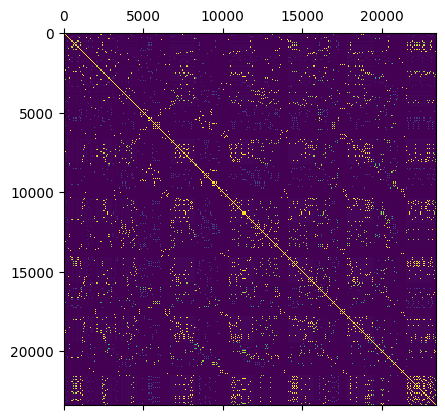

In [26]:
plt.matshow(kgauss)

# Train-test split, and regress

In [38]:
y = np.array(jijs)

In [27]:
ntot = len(jijs)

In [31]:
itrain = np.arange(ntot)[::3]
ntrain = len(itrain)
ntrain

576

In [33]:
np.random.seed(111)
np.random.shuffle(itrain)
itrain = itrain[:ntrain] # np.concatenate( (itrain[:ntrain] , [0,4,8,36,40,44,72,76,80]))
itest = np.setdiff1d(np.arange(ntot), itrain)
len(itest)

1152

In [34]:
#plt.plot(lx[itrain], ly[itrain], 'k*')
#plt.plot(lx[isparse], ly[isparse], 'r+')

In [35]:
#itrain = np.asarray([0,4,8,36,40,44,72,76,80])

In [39]:
w1 = np.linalg.lstsq( kernel[itrain][:,itrain]    + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]
w2 = np.linalg.lstsq( kernel[itrain][:,itrain]**2 + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]
wg = np.linalg.lstsq( kgauss[itrain][:,itrain]    + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]
wgopt = np.linalg.lstsq( kgopt[itrain][:,itrain]  + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]

In [40]:
ypred_z1 = kernel[:,itrain] @ w1
ypred_z2 = (kernel[:,itrain]**2) @ w2
ypred_g = (kgauss[:,itrain]) @ wg
ypred_gopt = (kgopt[:,itrain]) @ wgopt

In [42]:
ypred_z1.shape, ypred_z2.shape, ypred_g.shape, ypred_gopt.shape

((23392,), (23392,), (23392,), (23392,))

In [41]:
np.sqrt(np.mean((ypred_gopt - y)[itest]**2))

ValueError: operands could not be broadcast together with shapes (23392,) (1728,) 

In [53]:
(ypred_g-y)[itrain]

ValueError: operands could not be broadcast together with shapes (23392,) (1728,) 

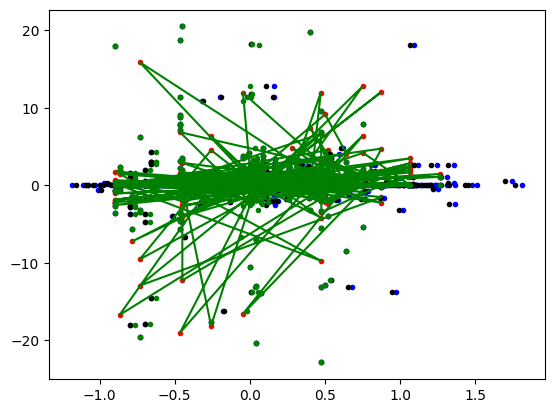

In [54]:
plt.plot(ypred_z1[itrain],y[itrain], 'r.')
plt.plot(ypred_z1[itest], y[itest], 'b.')
plt.plot(ypred_z2[itest], y[itest], 'k.')
plt.plot(ypred_g[itest], y[itest], 'g.')
plt.plot(ypred_g[itrain], y[itrain], 'g-')